In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import os
import copy
import math
import time 

import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torch.distributions import Gumbel,Bernoulli,Normal

#from torch.utils.tensorboard import SummaryWriter
#from torchviz import make_dot, make_dot_from_trace
#from tensorboardX import SummaryWriter

#from torchvision import datasets, transforms

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

# Model

In [2]:
import DataProcessing
from DataProcessing import *

In [3]:
import DSVMCode
from DSVMCode import *

### Reload Model as needed

In [4]:
import importlib
importlib.reload(DataProcessing)
from DataProcessing import *

<module 'DataProcessing' from '/home/xiuqin/DSVM/Code/DataProcessing.py'>

In [5]:
import importlib
importlib.reload(DSVMCode)
from DSVMCode import *

<module 'DSVMCode' from '/home/xiuqin/DSVM/Code/DSVMCode.py'>

In [6]:
# convert an array of values into a dataset matrix from 1-d time series
def create_dataset_unsupervised(dataset, look_back=1,predict_len = 1):
    dataY = []
    for i in range(0,len(dataset)-look_back+1,predict_len):
            a = dataset[i:(i+look_back), 0]
            dataY.append(a)
    return np.array(dataY) 

# Dataset Preprocessing

In [213]:
# Several companies
sp500_df = pd.read_csv("../DataDsf/sp500_return_01_18.csv")
sp500_df = sp500_df[~sp500_df['PERMNO'].isin(list(np.unique(sp500_df.loc[sp500_df['RETX'].isnull(),'PERMNO'].values)))]
sp500_df.rename(columns={'DATE': 'Date'}, inplace=True)

bigcompany_list = pd.read_csv("bigcompany_list.csv",header=None)
print("Number of Big Companies:",len(bigcompany_list))

## Specify the setting of the model
timestep = 10 # The past information used for prediction
predict_len = 1
predict_dim = 1 # The dimension of observations at each time step
look_back = predict_len * timestep

def ConstructDataset(sp500_df,PERMNO):
    
    ## The Raw data
    RawData = sp500_df.loc[sp500_df['PERMNO'] == PERMNO]
    RawData.reset_index(inplace=True)
    RawData.head()
    data = RawData['RETX'].values
    

    ## Split into train and text data, train data 0.6 vs validation 0.2 vs test data 0.2
    length = len(data)/predict_len
    train_len = int(length * 0.6)*predict_len
    valid_len = int(length * 0.2)*predict_len+100-timestep
    print(data.shape,train_len+valid_len) 
    train_valid_data = data[:(train_len+valid_len)]
    test_data  = data[(train_len+valid_len):]

    train_valid_data = train_valid_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)


    #print("train size (days):",train_data.shape[0],"valid size(days):",valid_data.shape[0],"test size(days):",test_data.shape[0])

    # ## Normalize the dataset
    # moments = normalize_moments(train_data)
    # train_data = normalize_fit(train_data,moments)
    # valid_data = normalize_fit(valid_data,moments)
    # test_data = normalize_fit(test_data,moments)
    # print('std:',train_data.std())


    ## Create training,validation and test dataset
    train_valid_Y = create_dataset_unsupervised(train_valid_data,look_back,predict_len)
    testY = create_dataset_unsupervised(test_data,look_back,predict_len)
    #print("2D size(Y):", train_valid_Y.shape,testY.shape)

    #Reshape to be 3D arrray
    train_valid_Y = np.reshape(train_valid_Y, (train_valid_Y.shape[0],timestep,predict_len))
    testY = np.reshape(testY, (testY.shape[0], timestep,predict_len))
    

    shuffle_index = torch.randperm(train_valid_Y.shape[0])
    trainY = train_valid_Y[shuffle_index[:train_len]]
    validY  = train_valid_Y[shuffle_index[train_len:]]
    print("3D size(Y):",trainY.shape,validY.shape,testY.shape)
    
    return trainY, validY, testY,train_valid_data,train_valid_Y

# np.savetxt("bigcompany_list.csv",bigcompany.index.values)

trainY_list = []
validY_list = []
testY_list = []
train_valid_Y_list = []
train_valid_Y_list2 = []
# for PERMNO  in list(np.unique(sp500_df['PERMNO'].values)):
for PERMNO  in  list(bigcompany_list.values[:,0]):
    trainY, validY, testY,train_valid_data,train_valid_Y = ConstructDataset(sp500_df,PERMNO)
    trainY_list.append(trainY)
    validY_list.append(validY)
    testY_list.append(testY)
    train_valid_Y_list.append(train_valid_data)
    train_valid_Y_list2.append(train_valid_Y)
    
trainY = np.array(trainY_list).reshape(-1,timestep,1)
validY = np.array(validY_list).reshape(-1,timestep,1)
testY = np.array(testY_list).reshape(-1,timestep,1)
train_valid_Y = np.array(train_valid_Y_list2).reshape(-1,timestep,1)

trainY = np.transpose(trainY, (1, 0, 2))
validY = np.transpose(validY, (1, 0, 2))
testY = np.transpose(testY, (1, 0, 2))
train_valid_Y = np.transpose(train_valid_Y, (1, 0, 2))
print("3D size(Y):",trainY.shape,validY.shape,testY.shape,train_valid_Y.shape)

print("Numpy into Tensor, done!")
trainY = torch.from_numpy(trainY).float()
validY = torch.from_numpy(validY).float()
testY = torch.from_numpy(testY).float()
train_valid_Y = torch.from_numpy(train_valid_Y).float()

Number of Big Companies: 39
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 1)
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 1)
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 1)
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 1)
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 1)
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 1)
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 1)
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 1)
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 1)
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 1)
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 1)
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 1)
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 1)
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 1)
(4527,) 3711
3D size(Y): (2716, 10, 1) (986, 10, 1) (807, 10, 

# Training

In [214]:
import torch
print(torch.__version__)

1.1.0


In [215]:
torch.cuda.is_available()

True

In [216]:
## Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print("Device:",device)
# trainX = trainX.to(device)
# validX = validX.to(device)
# testX = testX.to(device)
trainY = trainY.to(device)
validY = validY.to(device)
testY = testY.to(device)

Device: cuda


In [217]:
testY.device

device(type='cuda', index=0)

In [218]:
testY.dtype

torch.float32

In [219]:
testY.layout

torch.strided

In [220]:
import importlib
importlib.reload(DSVMCode)
from DSVMCode import *

<module 'DSVMCode' from '/home/xiuqin/DSVM/Code/DSVMCode.py'>

In [16]:
## Model Setting

## hyperparameters
y_dim = 1
h_dim = 10
z_dim = 1
n_layers =  1
n_epochs = 300
clip = 10
learning_rate = 1e-3
batch_size = 512

#print_every = 100
save_every = 1
save_best = True

directory = os.path.join("200906MultiCheckpoint39_10",'{}-{}-{}'.format(n_layers,z_dim,h_dim))
directoryBest = os.path.join(directory,'best')

##manual seed
#seed = 128
#torch.manual_seed(seed)
#plt.ion()

##init model + optimizer
model = DSVM(y_dim, h_dim, z_dim,n_layers,device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 5)


train Epoch:1	 KLD_Gaussian Loss: 0.119065, NLL Loss: -22.308518, Loss: -22.1895
valid Epoch:1	 KLD_Gaussian Loss: 0.118822, NLL Loss: -22.287442, Loss: -22.1686
test Epoch:1	 KLD_Gaussian Loss: 0.118874, NLL Loss: -23.963322, Loss: -23.8444
train Epoch:2	 KLD_Gaussian Loss: 0.019251, NLL Loss: -22.901219, Loss: -22.8820
valid Epoch:2	 KLD_Gaussian Loss: 0.019264, NLL Loss: -22.855075, Loss: -22.8358
test Epoch:2	 KLD_Gaussian Loss: 0.019203, NLL Loss: -24.396961, Loss: -24.3778
train Epoch:3	 KLD_Gaussian Loss: 0.009006, NLL Loss: -23.297657, Loss: -23.2887
valid Epoch:3	 KLD_Gaussian Loss: 0.008981, NLL Loss: -23.257771, Loss: -23.2488
test Epoch:3	 KLD_Gaussian Loss: 0.008959, NLL Loss: -24.830347, Loss: -24.8214
train Epoch:4	 KLD_Gaussian Loss: 0.005869, NLL Loss: -23.531364, Loss: -23.5255
valid Epoch:4	 KLD_Gaussian Loss: 0.005869, NLL Loss: -23.489580, Loss: -23.4837
test Epoch:4	 KLD_Gaussian Loss: 0.005874, NLL Loss: -25.078107, Loss: -25.0722
train Epoch:5	 KLD_Gaussian Loss

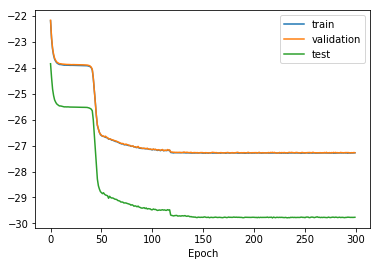

In [17]:
#writer = SummaryWriter()
## Training
start = time.time()
loss_train_list = []
loss_valid_list = []
loss_test_list = []
best_validation = 1e5


for epoch in range(1, n_epochs + 1):
    
    ### Training
    loss_train,(all_z_posterior_mean_train,all_z_posterior_std_train),(all_z_prior_mean_train, all_z_prior_std_train),all_z_t_sampled_train, all_y_emission_mean_train, all_y_emission_std_train, all_h_train = train(model,optimizer,trainY,epoch,batch_size)
    
    ### Validation
    loss_valid,(all_z_posterior_mean_valid,all_z_posterior_std_valid),(all_z_prior_mean_valid, all_z_prior_std_valid),all_z_t_sampled_valid, all_y_emission_mean_valid, all_y_emission_std_valid, all_h_valid  = test(model,validY,epoch,"valid")
    
    ### Testing
    loss_test,(all_z_posterior_mean_test,all_z_posterior_std_test),(all_z_prior_mean_test, all_z_prior_std_test),all_z_t_sampled_test, all_y_emission_mean_test, all_y_emission_std_test, all_h_test = test(model,testY,epoch,"test")
    
    ### Learning rate adjust
    scheduler.step(loss_valid)
    
    loss_train_list.append(loss_train)
    loss_valid_list.append(loss_valid)
    loss_test_list.append(loss_test)
    
    ### Save the results to tensorboard
#     writer.add_scalar("scalar/train_loss",loss_train,epoch)
#     writer.add_scalar("scalar/valid_loss",loss_valid,epoch)
    
    ### Save checkpoint
    if (epoch % save_every == 0):
        
        if not os.path.exists(directory):
            os.makedirs(directory)
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': loss_train,
            }, os.path.join(directory, '{}_{}.tar'.format(epoch, 'checkpoint')))
        
    if save_best:
        
        if not os.path.exists(directoryBest):
            os.makedirs(directoryBest)
        if (loss_valid < best_validation):
            best_validation = copy.deepcopy(loss_valid)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': loss_train,
            },os.path.join(directoryBest,'best.tar'))


print("Running Time:", time.time()-start)
plt.plot(np.array(loss_train_list),label="train")
plt.plot(np.array(loss_valid_list),label="validation")
plt.plot(np.array(loss_test_list),label="test")
plt.xlabel("Epoch")
plt.legend()
plt.show();

#writer.add_graph(model,trainY[:,0:1,:])
#writer.close()

Running Time: 3369.197920560837


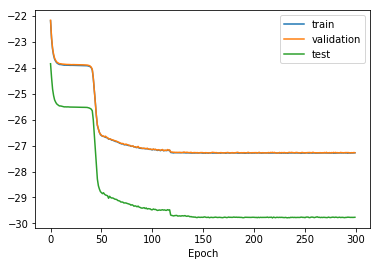

In [18]:
print("Running Time:", time.time()-start)
plt.plot(np.array(loss_train_list),label="train")
plt.plot(np.array(loss_valid_list),label="validation")
plt.plot(np.array(loss_test_list),label="test")
plt.xlabel("Epoch")
plt.legend()
plt.show();

In [19]:
next(model.parameters())

Parameter containing:
tensor([[0.1319],
        [1.2479]], device='cuda:0', requires_grad=True)

# Validation 
Chose the best model with best validation results

In [221]:
import importlib
importlib.reload(DSVMCode)
from DSVMCode import *

<module 'DSVMCode' from '/home/xiuqin/DSVM/Code/DSVMCode.py'>

In [222]:
directoryBest

'200906MultiCheckpoint39_10/1-1-10/best'

In [223]:
# Reload the parameters
print(directoryBest,os.listdir(directoryBest))
PATH = os.path.join(directoryBest,os.listdir(directoryBest)[0])
print(PATH)

200906MultiCheckpoint39_10/1-1-10/best ['best.tar']
200906MultiCheckpoint39_10/1-1-10/best/best.tar


In [224]:
model = DSVM(y_dim, h_dim, z_dim,n_layers,device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [225]:
## The Parameters
print("Epoch:",epoch)
total_params = sum(p.numel() for p in model.parameters())
#total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("The total number of parameters:",total_params)

Epoch: 204
The total number of parameters: 911


# Inference

In [227]:
model = model.to(device)

In [228]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(colors[:3])

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]


##  1. In Sample Posterior

### All the samples are put throught the model

In [40]:
# insample = torch.from_numpy(train_valid_data).float()
# insample = torch.unsqueeze(insample,1).to(device)

In [ ]:
comparemodel = "EGARCH"
GARCH_insample = pd.read_csv(comparemodel+"_insampel_vol.csv").iloc[:,1:]
index_company = 0

In [ ]:
insample = torch.from_numpy(np.transpose(train_valid_Y_list2[index_company],(1,0,2))).float()
insample.shape
insample = insample[:,:-1,:].to(device)
insample.shape

MC = 1000
forecaststep = 1

#forecast_y,forecast_vol = model._forecastingMultiStep(outsample, S= MC,step=forecaststep)
forecast_y,forecast_vol,forecast_z_mean,forecast_z_std,forecast_z = model._forecastingMultiStep(insample, S= MC,step=forecaststep)
forecast_y = np.squeeze(np.squeeze(forecast_y,1),2).transpose(1,0)
forecast_vol = np.squeeze(np.squeeze(forecast_vol,1),2).transpose(1,0)

forecast_y_mean = np.mean(forecast_y,1)
forecast_y_std = np.std(forecast_y,1)

forecast_z_mean = np.squeeze(np.squeeze(forecast_z_mean,1),2).transpose(1,0)
forecast_z_mean = np.mean(forecast_z_mean,1)    

PERMNO = bigcompany_list.values[index_company][0]
RawData = sp500_df.loc[sp500_df['PERMNO'] == PERMNO]
RawData.reset_index(inplace=True)

Date = RawData.iloc[timestep:(timestep+insample.shape[1])]['Date'].values
price = RawData.iloc[timestep:(timestep+insample.shape[1])]['PRC'].values
returnx = RawData.iloc[timestep:(timestep+insample.shape[1])]['RETX'].values
GARCH_insample_vol = GARCH_insample.iloc[timestep:(timestep+insample.shape[1]),index_company].values

GARCH_insample.shape
GARCH_insample_vol.shape

print(index_company,PERMNO)

length = insample.shape[1] #500
length_r = insample.shape[1]#np.random.randint(insample.shape[0])
length_l = length_r - length

## Make plot
fig,(ax0,ax1,ax2,ax3) = plt.subplots(4,1,figsize=(20, 6),sharex = True)

ax0.plot(price[length_l:length_r],label='price')
ax0.legend()

ax1.plot(returnx[length_l:length_r],label = "true return")
ax1.legend()

ax2.plot(forecast_y_std[length_l:length_r],alpha=1,color ='#ff7f0e',label = "Volatility")
ax2.plot(GARCH_insample_vol[length_l:length_r],alpha=1,color='green',label = "EGARCH Volatility")
ax2.legend()    

ax2.set_xticks(np.arange(0,length,int(length/8)))
ax2.set_xticklabels(Date[length_l:length_r][np.arange(0,length,int(length/8))])

ax3.plot(forecast_z_mean[length_l:length_r])

plt.suptitle("In sample forecasting")
plt.show();


length = 500
length_r = np.random.randint(501,insample.shape[1])
length_l = length_r - length

## Make plot
fig,(ax0,ax1,ax2,ax3) = plt.subplots(4,1,figsize=(20, 6),sharex = True)

ax0.plot(price[length_l:length_r],label='price')
ax0.legend()

ax1.plot(returnx[length_l:length_r],label = "true return")
ax1.legend()

ax2.plot(forecast_y_std[length_l:length_r],alpha=1,color ='#ff7f0e',label = "Volatility")
ax2.plot(GARCH_insample_vol[length_l:length_r],alpha=1,color='green',label = "EGARCH Volatility")
ax2.legend()    

ax2.set_xticks(np.arange(0,length,int(length/8)))
ax2.set_xticklabels(Date[length_l:length_r][np.arange(0,length,int(length/8))])

ax3.plot(forecast_z_mean[length_l:length_r])

plt.suptitle("In sample forecasting")
plt.show();
    

## 2. Forecasting

In [76]:
def likelihood_gauss(std, x):
    return  1/(np.sqrt(2*math.pi)*std) * np.exp(-np.power(x,2)/(2*np.power(std,2)))

In [77]:
def nll_mix_gauss(std, x):
    return  0.5*np.log(2*math.pi) + np.log(std)+ np.power(x,2)/(2*np.power(std,2))

In [83]:
model = model.to(device)

In [84]:
table = pd.DataFrame(columns = ['PERMON','NLL'])
predicted_volatility_list = []

In [85]:
forecast_z_mean_list = list()

In [ ]:
comparemodel = "EGARCH"
GARCH_outsample = pd.read_csv(comparemodel+"_outsampel_vol.csv").iloc[:,1:]
for index_company in range(bigcompany_list.values.shape[0]):
    #index_company = 0

    outsample = torch.from_numpy(np.transpose(testY_list[index_company],(1,0,2))).float()
    outsample = outsample[:,:-1,:].to(device)

    MC = 1000
    forecaststep = 1

    #forecast_y,forecast_vol = model._forecastingMultiStep(outsample, S= MC,step=forecaststep)
    forecast_y,forecast_vol,forecast_z_mean,forecast_z_std,forecast_z = model._forecastingMultiStep(outsample, S= MC,step=forecaststep)
    
    forecast_y = np.squeeze(np.squeeze(forecast_y,1),2).transpose(1,0)
    forecast_vol = np.squeeze(np.squeeze(forecast_vol,1),2).transpose(1,0)
    

    forecast_y_mean = np.mean(forecast_y,1)
    forecast_y_std = np.std(forecast_y,1)
    
    forecast_z_mean = np.squeeze(np.squeeze(forecast_z_mean,1),2).transpose(1,0)
    forecast_z_mean = np.mean(forecast_z_mean,1)
    
    predicted_volatility_list.append(forecast_y_std)
    
    PERMNO = bigcompany_list.values[index_company][0]
    RawData = sp500_df.loc[sp500_df['PERMNO'] == PERMNO]
    RawData.reset_index(inplace=True)
    
    GARCH_outsample_vol = GARCH_outsample.iloc[:,index_company].values

    length = 806
    length_r = outsample.shape[1]
    length_l = length_r - length

    Date = RawData.iloc[-outsample.shape[1]:]['Date'].values[length_l:length_r]
    price = RawData.iloc[-outsample.shape[1]:]['PRC'].values[length_l:length_r]
    returnx = RawData.iloc[-outsample.shape[1]:]['RETX'].values[length_l:length_r]
    
    
    y_mean = forecast_y_mean[length_l:length_r]
    y_std = forecast_y_std[length_l:length_r]

    fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(20, 8),sharex = True)

    ax1.plot(price,alpha=1,label = "price")

    ax2.plot(returnx,alpha=1,label='true return');
    ax2.plot(y_mean,alpha=1,label='predicted return mean');
    #ax2.plot(y_mean-y_std,alpha=1,color='grey');
    #ax2.plot(y_mean+y_std,alpha=1,color='grey');
    ax2.fill_between(np.arange(y_mean.shape[0]),y_mean - 1.96*y_std,y_mean + 1.96*y_std,color='grey',alpha=0.3)

    ax3.plot(y_std,alpha=1,color='#ff7f0e',label='predicted volatility')
    ax3.plot(GARCH_outsample_vol[length_l:length_r],alpha=1,color='green',label='predicted volatility(EGARCH)')
    ax4.plot(forecast_z_mean)
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    # ax3.set_xticks(np.arange(0,outsample.shape[1],100))
    # ax3.set_xticklabels(Date[np.arange(0,outsample.shape[1],100)])

    ax2.set_xticks(np.arange(0,length,int(length/5)))
    ax2.set_xticklabels(Date[np.arange(0,length,int(length/5))])

    plt.suptitle("Recursive one-day-ahead forecasting");
    plt.show();


    #nll_test = np.mean(nll_mix_gauss(forecast_vol,np.expand_dims(returnx,1)),axis=1)
    nll_test = -np.log(np.mean(likelihood_gauss(forecast_vol, np.expand_dims(returnx,1)),axis=1))
    print(index_company,"PERMON:",bigcompany_list.values[index_company,0],"Negative Loglikelihood is:",np.mean(nll_test))
    forecast_z_mean_list.append(np.mean(forecast_z_mean))
    
    table =  table.append({'PERMON': bigcompany_list.values[index_company,0], 'NLL': np.mean(nll_test)},ignore_index=True)
    

In [89]:
predicted_volatility_table = pd.DataFrame(np.array(predicted_volatility_list).T)
predicted_volatility_table.columns = list(bigcompany_list.values[:,0])
predicted_volatility_table.head()

,10104.0,10107.0,11308.0,11850.0,12060.0,12490.0,13856.0,13901.0,13928.0,14008.0,...,65875.0,66093.0,66181.0,66800.0,70519.0,76076.0,77178.0,83443.0,84788.0,92655.0
0,0.010526,0.011005,0.010056,0.012633,0.018416,0.010706,0.012357,0.011636,0.012430,0.021510,...,0.011018,0.009820,0.011313,0.012489,0.017520,0.011489,0.013233,0.012022,0.018215,0.017688
1,0.011350,0.010025,0.009605,0.013825,0.017108,0.010282,0.011580,0.012084,0.015943,0.019810,...,0.010203,0.009727,0.010932,0.012889,0.015818,0.009538,0.013657,0.011978,0.016792,0.015412
2,0.011471,0.009882,0.009589,0.013173,0.014819,0.029035,0.010699,0.011802,0.013677,0.021472,...,0.010737,0.010371,0.010090,0.012209,0.015904,0.009866,0.012899,0.011923,0.018045,0.013805
3,0.011883,0.010398,0.008824,0.013408,0.014484,0.022256,0.010214,0.010672,0.014565,0.017958,...,0.010671,0.009398,0.010965,0.011592,0.017095,0.010086,0.012437,0.011046,0.017436,0.015910
4,0.015279,0.011648,0.012030,0.016840,0.016273,0.020730,0.014009,0.014059,0.017355,0.019015,...,0.013227,0.010322,0.010213,0.011118,0.017243,0.012850,0.014242,0.016875,0.017546,0.022361


In [90]:
# #table.to_csv("DSVM_NLL_test_200814.csv",sep=',')
# #predicted_volatility_table.to_csv("DSVM_outsample_vol_200814.csv",sep=',')

# table.to_csv("DSVM_NLL_test_200830.csv",sep=',')
# predicted_volatility_table.to_csv("DSVM_outsample_vol_200830.csv",sep=',')

table.to_csv("DSVM_NLL_test_200906_10.csv",sep=',')
predicted_volatility_table.to_csv("DSVM_outsample_vol_200906_10.csv",sep=',')

## Plot out of sample predicted volatility for all companies (already calculated)

In [231]:
import seaborn as sns
sns.set()

In [235]:
DSVM_outsample = pd.read_csv("DSVM_outsample_vol_200906_10.csv").iloc[:,1:]

In [ ]:
comparemodel = "EGARCH"
GARCH_outsample = pd.read_csv(comparemodel+"_outsampel_vol.csv").iloc[:,1:]

for index_company in range(39):# 6#np.random.randint(39)
    
    PERMNO = bigcompany_list.values[index_company][0]
    RawData = sp500_df.loc[sp500_df['PERMNO'] == PERMNO]
    RawData.reset_index(inplace=True)
    #RawData.head()
    
    GARCH_outsample_vol = GARCH_outsample.iloc[:,index_company].values
    #GARCH_outsample_vol.shape

    DSVM_outsample_vol = DSVM_outsample.iloc[:,index_company].values
    #DSVM_outsample_vol.shape

    length = 806#250
    length_r = 806#outsample.shape[1]#np.random.randint(length,outsample.shape[1])
    length_l = length_r - length

#     Date = RawData.iloc[-outsample.shape[1]:]['Date'].values[length_l:length_r]
#     price = RawData.iloc[-outsample.shape[1]:]['PRC'].values[length_l:length_r]
#     returnx = RawData.iloc[-outsample.shape[1]:]['RETX'].values[length_l:length_r]
    Date = RawData.iloc[-length:]['Date'].values[length_l:length_r]
    price = RawData.iloc[-length:]['PRC'].values[length_l:length_r]
    returnx = RawData.iloc[-length:]['RETX'].values[length_l:length_r]

    y_std = DSVM_outsample_vol[length_l:length_r]
    
    label = 'Volatility (' + comparemodel + ')'

    fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20, 6),sharex = True);

    ax1.plot(price,alpha=1,label = "price");

    ax2.plot(returnx,alpha=1,label='true return');

    ax3.plot(y_std,alpha=1,color='#ff7f0e',label='Volatility (DSVM)');
    ax3.plot(GARCH_outsample_vol[length_l:length_r],alpha=1,color='green',label = label);

    ax1.legend();
    ax2.legend();
    ax3.legend();

    # ax3.set_xticks(np.arange(0,outsample.shape[1],100))
    # ax3.set_xticklabels(Date[np.arange(0,outsample.shape[1],100)])

    ax2.set_xticks(np.arange(0,length,int(length/5)));
    ax2.set_xticklabels(Date[np.arange(0,length,int(length/5))]);

    #plt.suptitle("Out of sample");"Recursive one-day-ahead forecasting"
    
    print(index_company,PERMNO)
    plt.savefig("20200908_images_"+ comparemodel + "/stock%i_outsample"%index_company,bbox_inches='tight');
    plt.show();